In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2, VGG19, DenseNet121
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras import layers

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imutils

In [ ]:
from imutils import paths

In [ ]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/Skripsi/data_warna")))

# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

520 images (611.52MB)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [ ]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(520, 224, 224, 3)


In [ ]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 6 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. lv1
2. lv2
3. lv3
4. lv4
5. lv5
6. lv6


In [ ]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
bs = 8
lr = 0.001
size = (224, 224)
shape = (224,224, 3)
epochs = 20
class_number = 6

In [ ]:

def DenseNet_model(learning_rate, input_shape,class_number):
    densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape)

    for layer in densenet.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(densenet)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(layers.Dense(class_number, activation='softmax'))

    return model


In [ ]:
model = DenseNet_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1024)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

In [ ]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

In [ ]:
print("[INFO] training ...")
H = model.fit(aug.flow(trainX, trainY, batch_size=bs),steps_per_epoch=len(trainX) // bs,	validation_data=(testX, testY),	validation_steps=len(testX) // bs,	epochs=epochs)

[INFO] training ...
Epoch 1/20
13/13 [==============================] - 31s 1s/step - loss: 6.2366 - accuracy: 0.2067 - val_loss: 2.4092 - val_accuracy: 0.3365
Epoch 2/20
13/13 [==============================] - 6s 477ms/step - loss: 2.7734 - accuracy: 0.3149 - val_loss: 1.7966 - val_accuracy: 0.2692
Epoch 3/20
13/13 [==============================] - 12s 939ms/step - loss: 1.6713 - accuracy: 0.3654 - val_loss: 1.5473 - val_accuracy: 0.3462
Epoch 4/20
13/13 [==============================] - 6s 468ms/step - loss: 1.5578 - accuracy: 0.3293 - val_loss: 1.5094 - val_accuracy: 0.2981
Epoch 5/20
13/13 [==============================] - 5s 372ms/step - loss: 1.3883 - accuracy: 0.4279 - val_loss: 1.5565 - val_accuracy: 0.3077
Epoch 6/20
13/13 [==============================] - 6s 504ms/step - loss: 1.3583 - accuracy: 0.4567 - val_loss: 1.5034 - val_accuracy: 0.3365
Epoch 7/20
13/13 [==============================] - 5s 374ms/step - loss: 1.3012 - accuracy: 0.4736 - val_loss: 1.4990 - val_accu

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=bs)
y_predict =predIdxs
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification reportD
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
4/4 [==============================] - 4s 578ms/step
              precision    recall  f1-score   support

         lv1       0.78      0.64      0.70        11
         lv2       0.44      0.61      0.51        18
         lv3       0.45      0.22      0.29        23
         lv4       0.36      0.90      0.51        20
         lv5       0.62      0.20      0.30        25
         lv6       0.00      0.00      0.00         7

    accuracy                           0.44       104
   macro avg       0.44      0.43      0.39       104
weighted avg       0.48      0.44      0.40       104



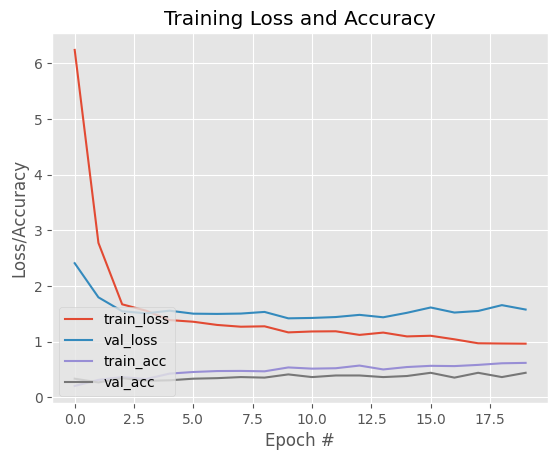

In [ ]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

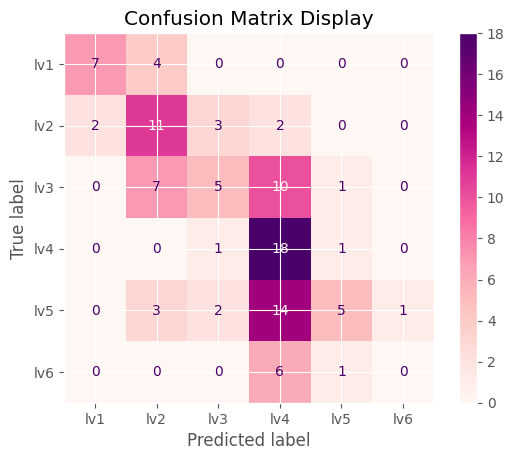

In [ ]:
# Pembuatan Confusion Matrix Display
cmd= metrics.confusion_matrix(testY.argmax(axis=1), np.argmax(y_predict, axis=1))
display_label = ['lv1','lv2','lv3','lv4','lv5','lv6']

cm_lr= ConfusionMatrixDisplay(cmd, display_labels = display_label )
cm_lr.plot(cmap=plt.cm.RdPu)
plt.title("Confusion Matrix Display")

plt.show()

In [ ]:
#model.save('/content/drive/MyDrive/Skripsi/model/densenet_warna_model_1.h5')